In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib
from scipy.spatial import cKDTree

# Step 1: Generate a set of 2D points
np.random.seed(0)  # For reproducibility
num_points = 500# You can adjust the number of points as needed
cube_length = 20
voxel_resolution = 2**9
points = np.random.uniform(-10, 10, size=(num_points, 2))
masses = np.random.uniform(1, 10, size=(1,num_points))

points[0] = np.array([1,1])
points[1] = np.array([2,2])
points[2] = np.array([1.2,1.1])
# points = np.array([[2,8],[-2,-8],[0,0]])


bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers]) # kpc


xx = np.meshgrid(bins, bins)[0]
yy = np.meshgrid(bins, bins)[1]

xx_c = np.meshgrid(bin_centers,bin_centers)[0]
yy_c = np.meshgrid(bin_centers,bin_centers)[1]

# voxel_centers 

grid_c = np.dstack(np.array([xx_c,yy_c])).reshape(-1,2)


l = len(bins)
grid_points_1 = np.vstack((xx[0:l-1,1:  l].ravel(), yy[0:l-1,1:  l].ravel())).T
grid_points_2 = np.vstack((xx[0:l-1,0:l-1].ravel(), yy[0:l-1,0:l-1].ravel())).T
grid_points_3 = np.vstack((xx[1:  l,0:l-1].ravel(), yy[1:  l,0:l-1].ravel())).T
grid_points_4 = np.vstack((xx[1:  l,1:  l].ravel(), yy[1:  l,1:  l].ravel())).T

voxel_vertices = np.array([grid_points_1 ,grid_points_2,grid_points_3,grid_points_4])
voxel_vertices = np.swapaxes(voxel_vertices, 0, 1)

In [124]:
np.shape(np.load("../data/FIRE/non-empty-coords-dark_mat.npy"))

(1895169, 3)

In [123]:
512**3

134217728

In [120]:
2**9

512

In [97]:
binned_points, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_points = binned_points[0]

select_binned_points = np.reshape(binned_points,(256,))!=0

In [115]:
t0 = timeit.default_timer()
tree_points = cKDTree(np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose())
indices = tree_points.query(grid_c)[1]
tf = timeit.default_timer()
print(tf - t0)

0.050510311499238014


In [114]:
t0 = timeit.default_timer()
grid_ids = np.argmin(distance.cdist(grid_c, np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()), axis=1)
tf = timeit.default_timer()
print(tf - t0)

0.0009404076263308525


In [117]:
non_empty_points = binned_points!=0

grid_ids = np.argmin(distance.cdist(grid_c, np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()), axis=1)

tree_points = cKDTree(np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose())
grid_ids = tree_points.query(grid_c)[1]

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**2)
quantity = np.reshape(binned_points, voxel_resolution**2)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution))

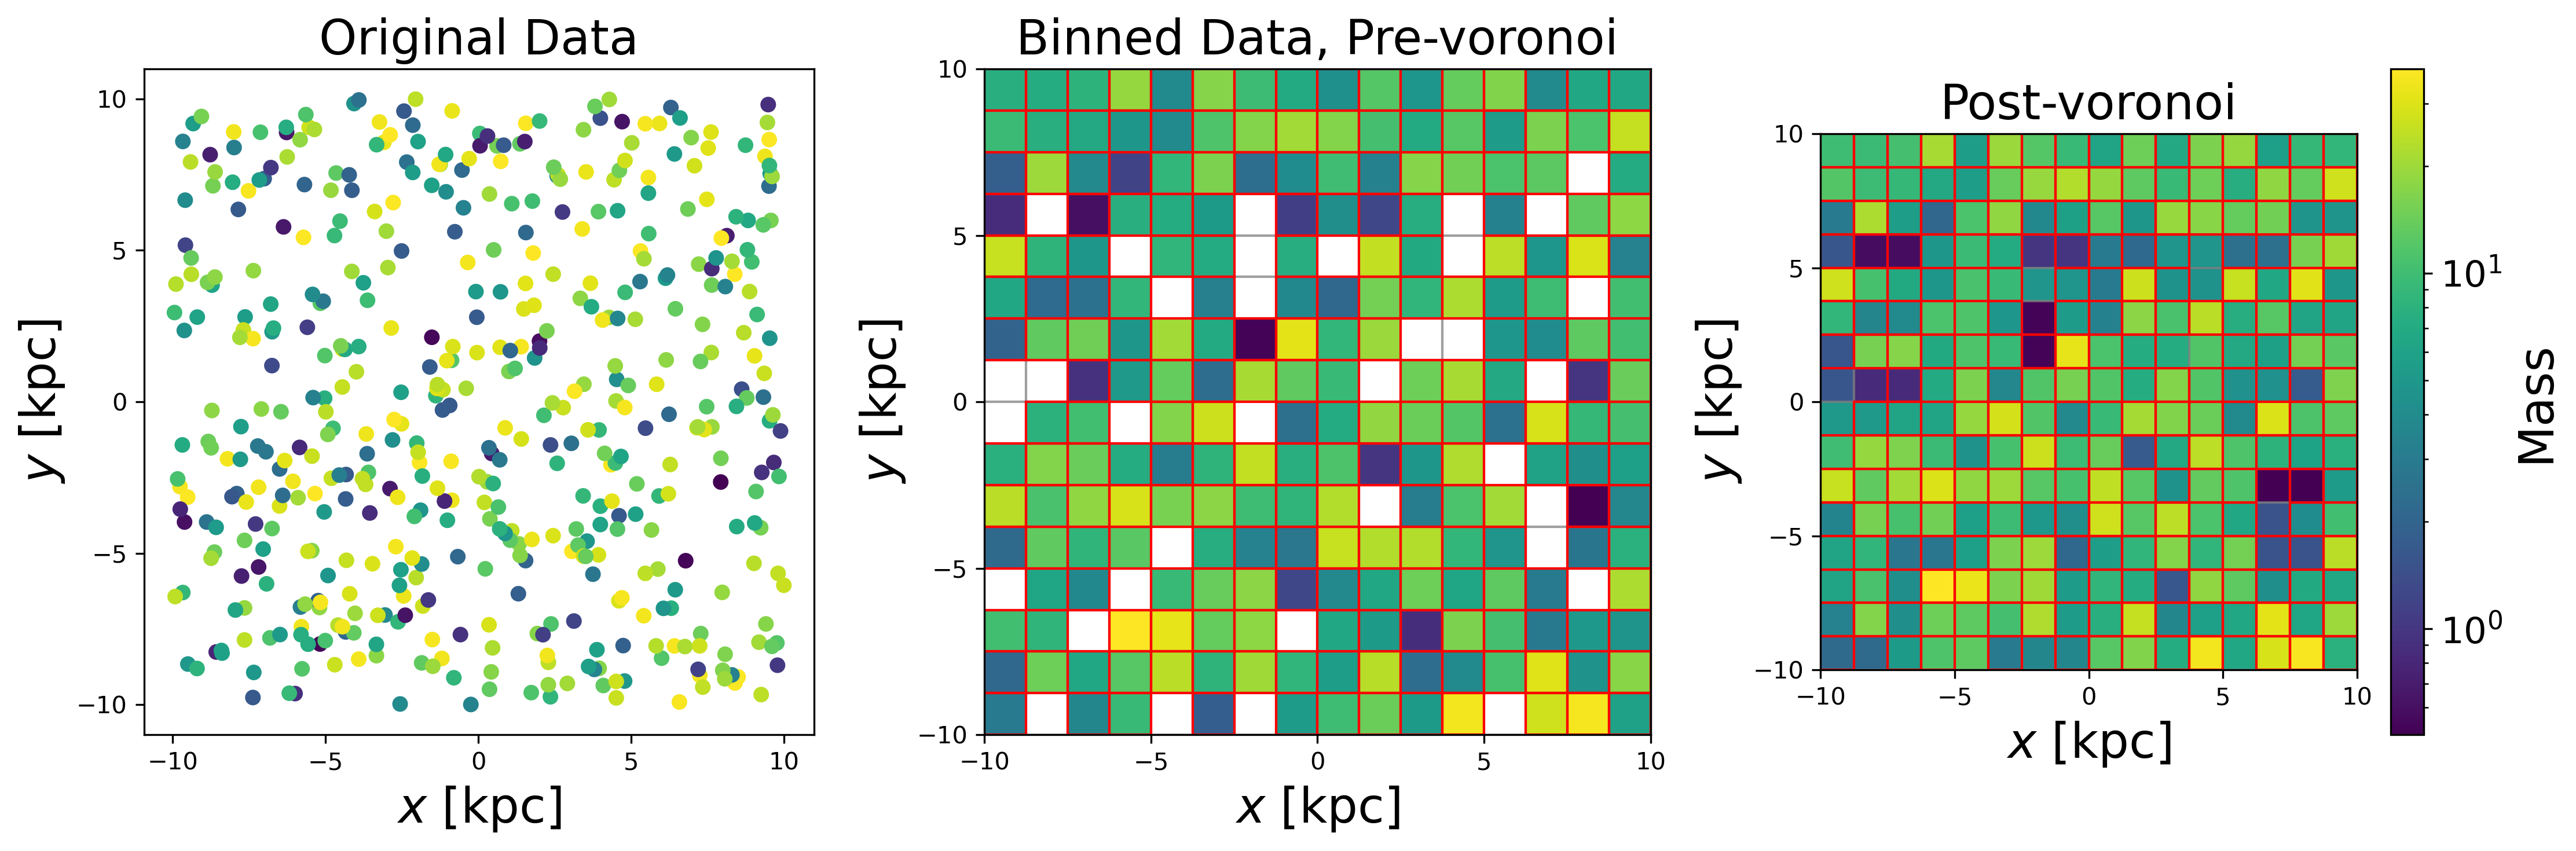

In [118]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

# Subplot 1: Original Data
sc = axs[0].scatter(points[:, 0], points[:, 1], c=masses, cmap='viridis', s=30, norm=matplotlib.colors.LogNorm())
# cbar = plt.colorbar(sc, ax=axs[0])
axs[0].set_title("Original Data", size=20)
axs[0].set_xlabel('$x$ [kpc]', size=20)
axs[0].set_ylabel('$y$ [kpc]', size=20)
axs[0].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[0].set_yticks(np.array([-10, -5, 0, 5, 10]))
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label("Mass", fontsize=20)

# Subplot 2: Binned Data, Pre-voronoi
axs[1].imshow(binned_points.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[1].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[1].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
axs[1].set_title("Binned Data, Pre-voronoi", size=20)
axs[1].set_xlabel('$x$ [kpc]', size=20)
axs[1].set_ylabel('$y$ [kpc]', size=20)
axs[1].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[1].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Subplot 3: Post-voronoi
im = axs[2].imshow(voronoied_result.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[2].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[2].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
cbar = plt.colorbar(im, ax=axs[2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Mass", fontsize=20)
axs[2].set_title("Post-voronoi", size=20)
axs[2].set_xlabel('$x$ [kpc]', size=20)
axs[2].set_ylabel('$y$ [kpc]', size=20)
axs[2].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[2].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
np.shape(quantity)

(256,)

In [55]:
# voronoied_result

In [53]:
np.shape(binned_points)

(16, 16)

In [16]:
np.shape(grid_c)

(256, 2)

In [73]:
points = np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()

In [74]:
points

array([[ 8.125, -0.625],
       [ 0.625,  0.625],
       [ 1.875,  1.875],
       [-1.875,  9.375]])

In [82]:
R = 500
tree_grid = cKDTree(grid_c)
tree_points = cKDTree(points)

# tree_grid.query_ball_point(points, R)
# tree_grid.query_ball_tree(tree_points, R)
indices = tree_points.query(grid_c)[1]
np.shape(indices)

(256,)

In [81]:
grid_ids

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 0, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0])

In [78]:
indices - grid_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
non_empty_points = binned_points!=0
non_empty_points

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, Fals

In [45]:
np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()

array([[ 8.125, -0.625],
       [ 0.625,  0.625],
       [ 1.875,  1.875],
       [-1.875,  9.375]])

In [46]:
points

array([[ 1.        ,  1.        ],
       [ 2.        ,  2.        ],
       [ 1.2       ,  1.1       ],
       [-1.24825577,  7.83546002],
       [ 9.27325521, -2.33116962]])

In [43]:
binned_points

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0